# Closed-Loop Navigation in a 2D World

## Problem Statement

We simulate a minimal robot navigating from a start position to a goal
in a 2D grid world with obstacles.

The robot:
- is represented as a point (dot)
- moves one step at a time (up, down, left, right)
- must avoid obstacles
- replans continuously based on feedback (closed-loop)

We build a minimal autonomy stack:
1. World model (occupancy grid)
2. Global planner (A*)
3. Local execution (step-by-step)
4. Closed-loop replanning
5. Simple evaluation

This notebook is about **understanding system behavior and failure modes**,
not optimizing algorithms.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# 0 = free space, 1 = obstacle
world = np.zeros((10, 10))

# Add obstacles
world[3, 2:8] = 1
world[6, 1:7] = 1

start = (0, 0)
goal = (9, 9)

world


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

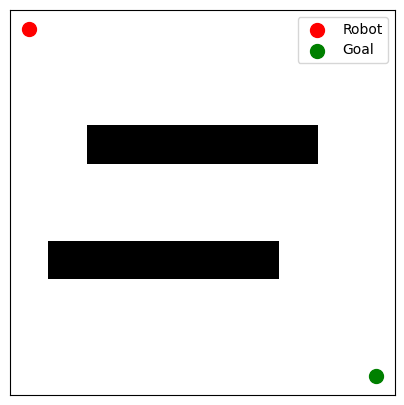

In [13]:
def draw_world(world, robot=None, path=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(world, cmap="gray_r")

    if path:
        py, px = zip(*path)
        plt.plot(px, py, "b--", linewidth=2, label="Planned Path")

    if robot:
        plt.scatter(robot[1], robot[0], c="red", s=100, label="Robot")

    plt.scatter(goal[1], goal[0], c="green", s=100, label="Goal")
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    plt.show()

draw_world(world, start)


In [14]:
import heapq

def astar(world, start, goal):
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    open_set = []
    heapq.heappush(open_set, (0, start, []))
    visited = set()

    while open_set:
        cost, current, path = heapq.heappop(open_set)

        if current in visited:
            continue
        visited.add(current)

        if current == goal:
            return path + [current]

        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = current[0] + dx, current[1] + dy
            if 0 <= nx < world.shape[0] and 0 <= ny < world.shape[1]:
                if world[nx, ny] == 0:
                    priority = cost + 1 + heuristic((nx, ny), goal)
                    heapq.heappush(
                        open_set,
                        (priority, (nx, ny), path + [current])
                    )
    return None


In [15]:
def local_step(robot, path):
    """
    Execute one step along the planned path.
    """
    if path is None or len(path) < 2:
        return robot
    return path[1]


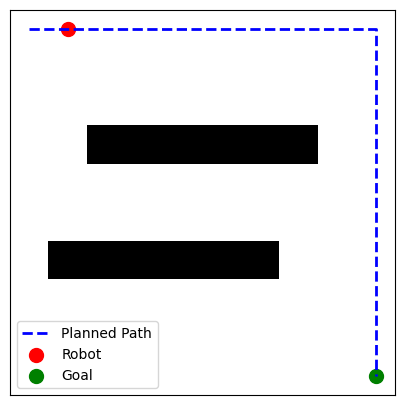

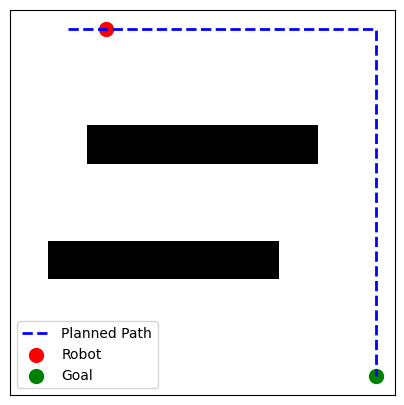

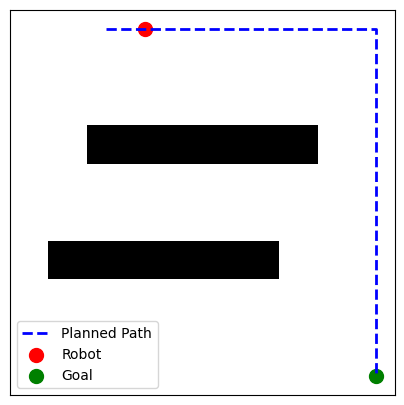

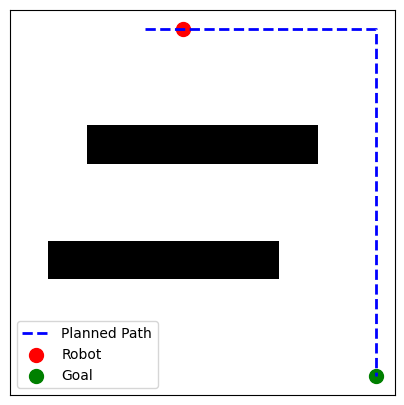

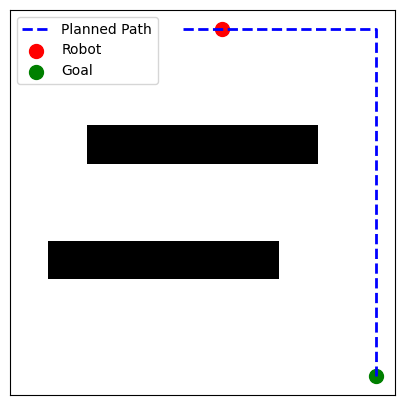

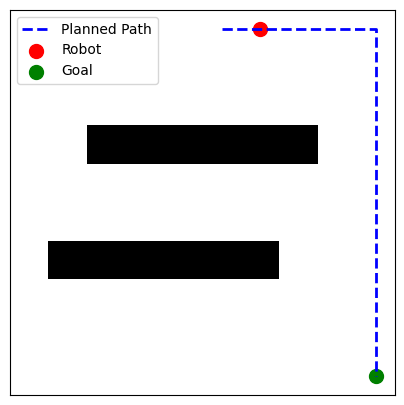

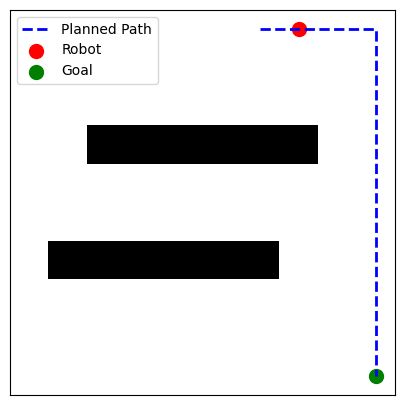

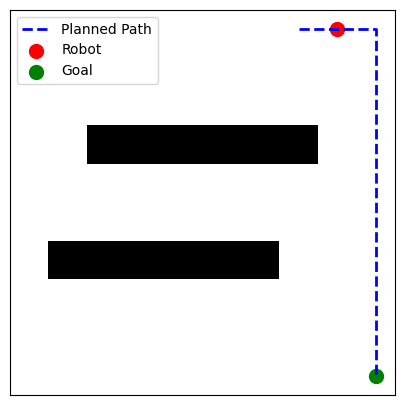

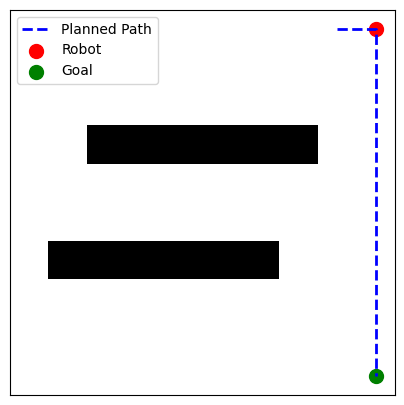

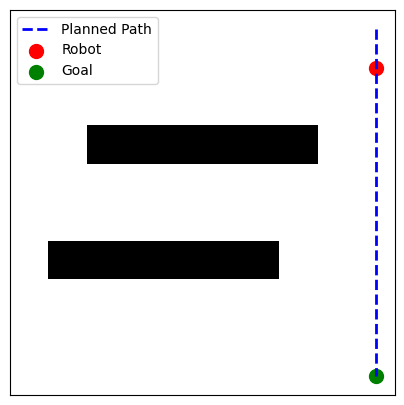

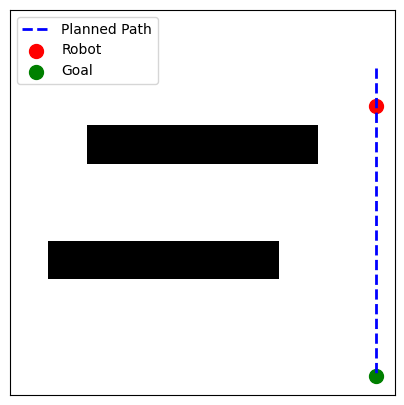

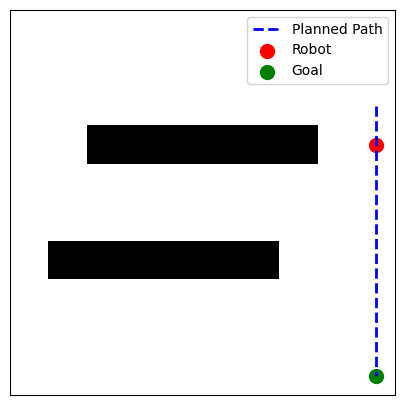

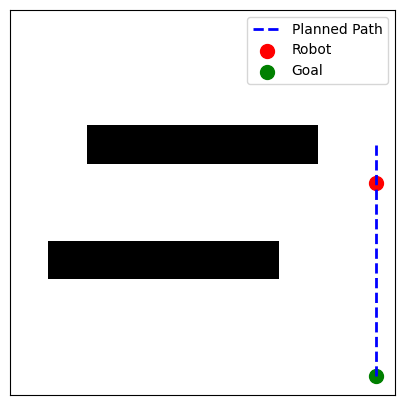

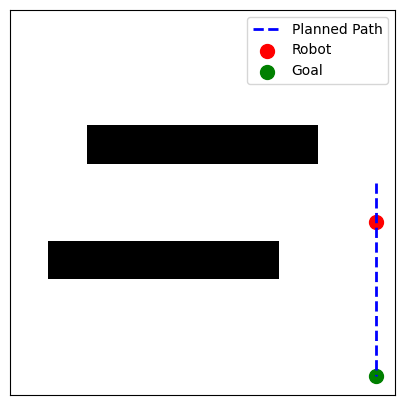

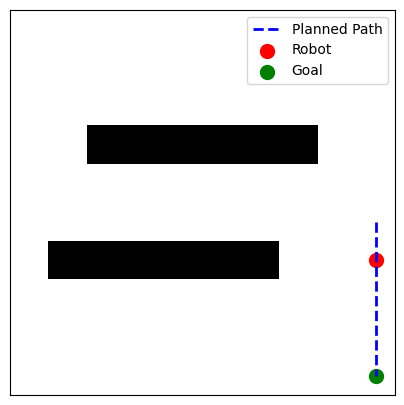

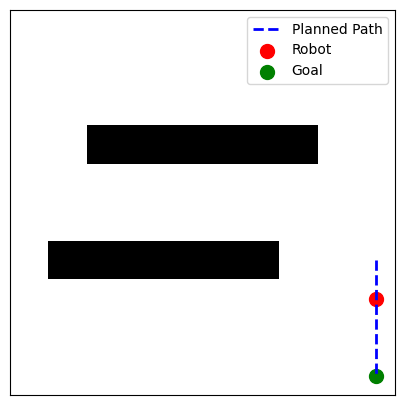

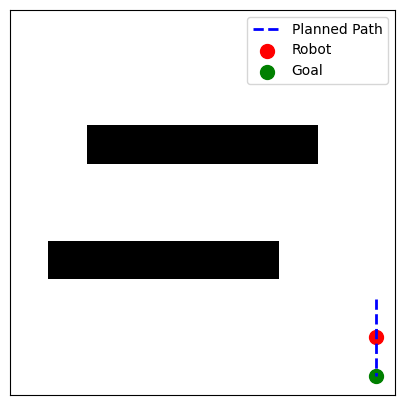

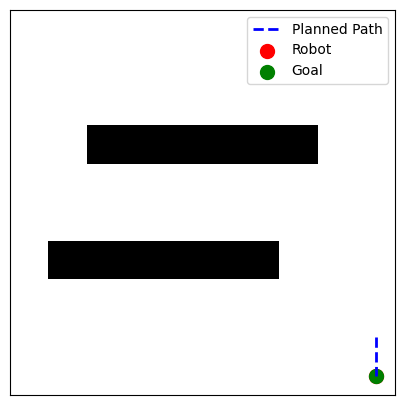

Goal reached!


In [16]:
robot = start
trajectory = [robot]

max_steps = 50

for step in range(max_steps):
    path = astar(world, robot, goal)

    if path is None:
        print("No path found — robot is stuck.")
        break

    robot = local_step(robot, path)
    trajectory.append(robot)

    draw_world(world, robot, path)

    if robot == goal:
        print("Goal reached!")
        break


In [17]:
success = robot == goal
steps_taken = len(trajectory)

print("Success:", success)
print("Steps taken:", steps_taken)
print("Trajectory:", trajectory)


Success: True
Steps taken: 19
Trajectory: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]


## Experiments to Try

Modify one thing at a time:
- Move obstacles closer together
- Create narrow passages
- Place goal behind obstacles
- Block and unblock paths mid-run

Observe:
- oscillations
- deadlocks
- long detours
- misleading success metrics

These behaviors directly mirror real robotics navigation failures.


## What This Notebook Demonstrates

- Navigation is a closed-loop problem
- Planning ≠ acting
- Small environment changes cause failure
- Success rate alone is misleading
- Evaluation depends heavily on scenarios

This is the minimal abstraction underlying real systems
like ROS Nav2, CARLA, and Habitat.


## Reflection

Answer the following in your own words:

1. Where did the system fail?
2. What metric hid poor behavior?
3. What scenario was hardest?
4. What would a benchmark need to expose this reliably?

Bring these answers before reading the Nav2 paper.
